In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder ,StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

In [5]:
# Load the dataset
df = pd.read_csv('Wholesale-Price-Index-from-2012-to-2024.csv')

# Display the first few rows of the dataset
print(df.head())

                 Crop  January-2013  January-2014  January-2015  January-2016  \
0               Bajra         131.6         132.3         125.0         142.9   
1              Barley         119.4         123.9         135.4         138.5   
2          Castorseed          83.7          93.0          94.9          79.9   
3              Cotton          91.8         111.7          86.5          90.4   
4  Cotton (Meal/Cake)         109.2         120.2         119.5         154.9   

   January-2017  January-2018  January-2019  January-2020  January-2021  ...  \
0         151.9         131.7         171.2         201.6         148.3  ...   
1         161.6         141.6         159.2         180.4         151.6  ...   
2          87.9          97.9         121.8         101.5         107.5  ...   
3         111.4         110.6         115.5         109.0         109.9  ...   
4         159.5         141.7         151.5         156.7         159.5  ...   

   December-2015  December-2016 

## Basic Infromation About our Dataset 

In [6]:
# List of unique crops
unique_crops = df['Crop'].unique()
print("Unique Crops:", unique_crops)
print("Number of Unique Crops:", len(unique_crops))

Unique Crops: ['Bajra' 'Barley' 'Castorseed' 'Cotton' 'Cotton (Meal/Cake)' 'Cotton Oil'
 'Gram' 'Groundnut' 'Groundnut Oil' 'Jowar' 'Jute' 'Lentil' 'Linseed'
 'Maize' 'Mesta' 'Moong' 'Nigerseed' 'Onion' 'Paddy' 'Palm oil' 'Peas'
 'Potato' 'Ragi' 'Rajma' 'Rapeseed & Mustard'
 'Rapeseed & Mustard (Meal/Cake)' 'Rapeseed & Mustard Oil' 'Rice'
 'Safflower' 'Sesamum' 'Soya oil' 'Soybean' 'Sugarcane' 'Sunflower'
 'Sunflower oil' 'Tobacco' 'Tomato' 'Tur' 'Urad' 'Wheat' 'Wheat Atta']
Number of Unique Crops: 41


In [7]:
# Column names and data types
print("Columns and Data Types:")
print(df.info())

Columns and Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Columns: 154 entries, Crop to December-2024
dtypes: float64(153), object(1)
memory usage: 49.5+ KB
None


In [8]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())

Missing Values:
Crop             0
January-2013     0
January-2014     0
January-2015     0
January-2016     0
                ..
December-2020    0
December-2021    0
December-2022    0
December-2023    0
December-2024    0
Length: 154, dtype: int64


In [9]:
# Melt the dataframe to long format
df_long = df.melt(id_vars=['Crop'], var_name='Date', value_name='Price')

# Convert Date to datetime format
df_long['Date'] = pd.to_datetime(df_long['Date'], format='%B-%Y')

# Sort by Crop and Date
df_long = df_long.sort_values(by=['Crop', 'Date'])

# Add month as an additional feature
df_long['Month'] = df_long['Date'].dt.month

# Display the reshaped dataframe
print(df_long.head())

# Fit the MinMaxScaler on actual price history
scaler = MinMaxScaler()
scaler.fit(df_long[['Price']])

# Save the fitted scaler
joblib.dump(scaler, "scaler.pkl")

print("Fitted scaler saved successfully with actual dataset!")

       Crop       Date  Price  Month
1476  Bajra 2012-04-01  107.7      4
2009  Bajra 2012-05-01  109.3      5
2542  Bajra 2012-06-01  107.0      6
3075  Bajra 2012-07-01  113.9      7
3608  Bajra 2012-08-01  120.7      8
Fitted scaler saved successfully with actual dataset!


## Data Visualization 

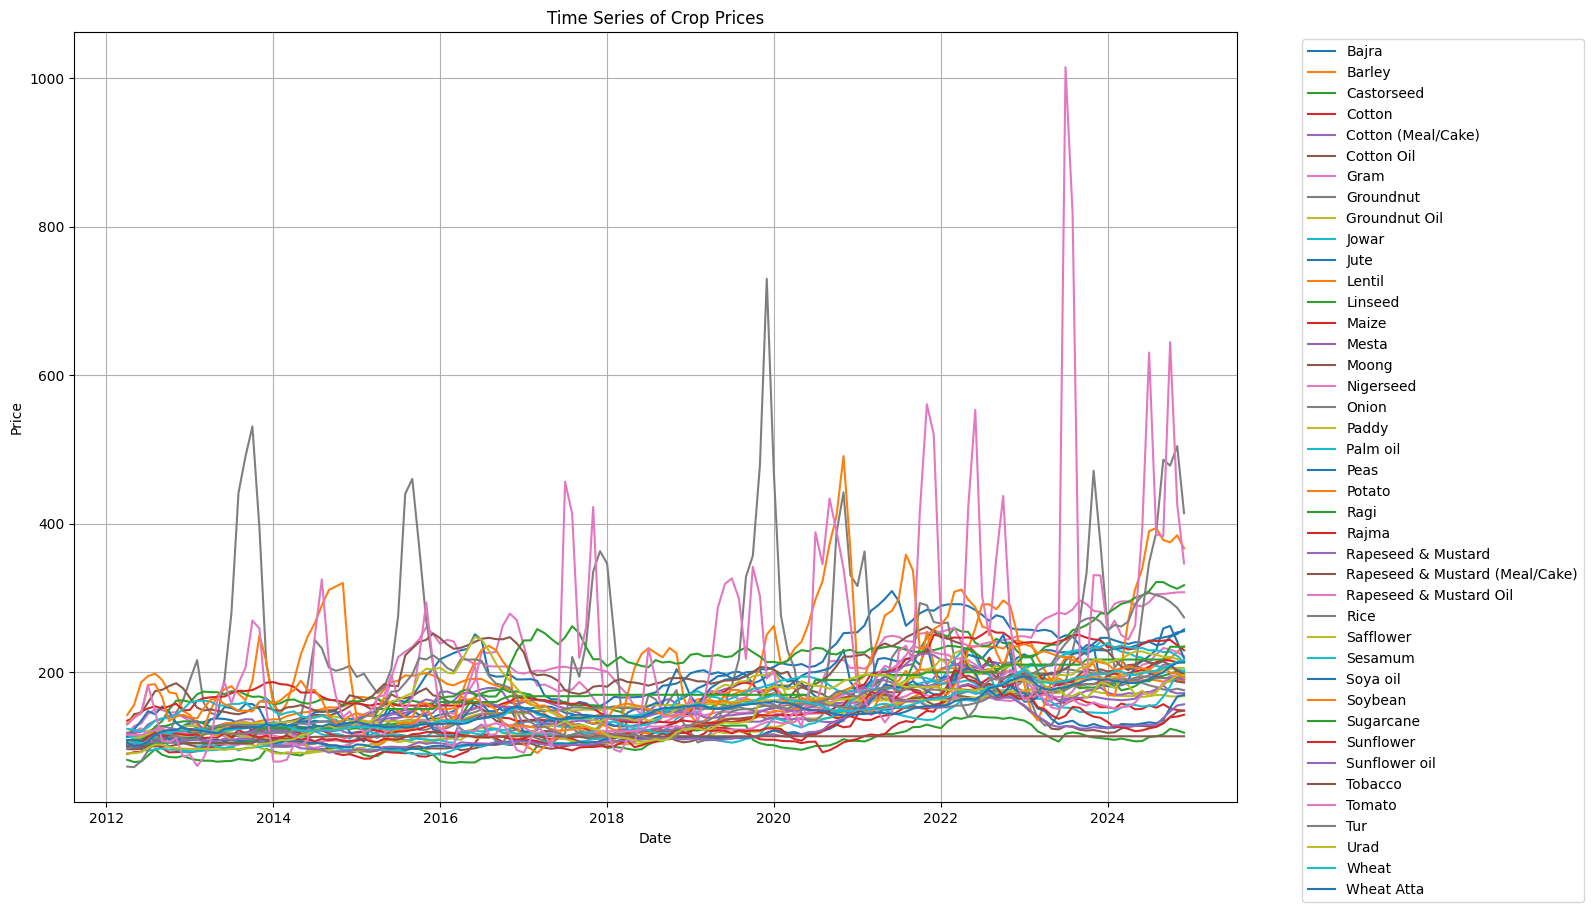

In [10]:
# Plot time series for each crop
plt.figure(figsize=(15, 10))
for crop in df_long['Crop'].unique():
    crop_data = df_long[df_long['Crop'] == crop]
    plt.plot(crop_data['Date'], crop_data['Price'], label=crop)

plt.title('Time Series of Crop Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()

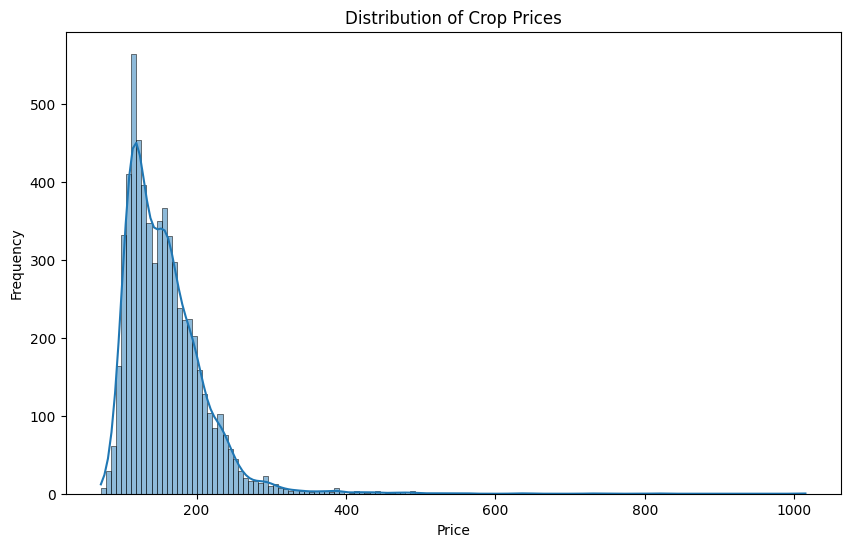

In [11]:
# Plot distribution of prices
plt.figure(figsize=(10, 6))
sns.histplot(df_long['Price'], kde=True)
plt.title('Distribution of Crop Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

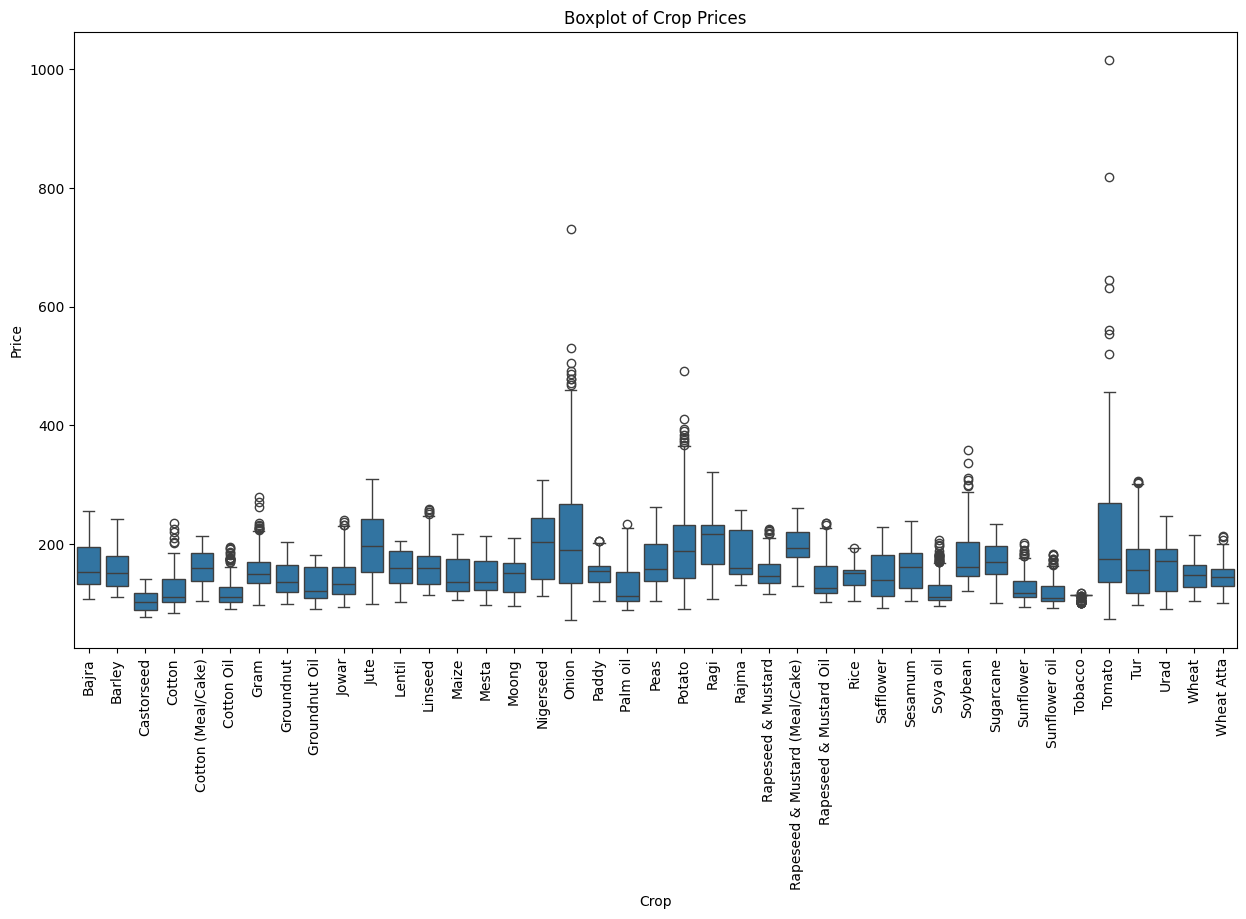

In [12]:
# Boxplot of prices by crop
plt.figure(figsize=(15, 8))
sns.boxplot(x='Crop', y='Price', data=df_long)
plt.title('Boxplot of Crop Prices')
plt.xlabel('Crop')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.show()

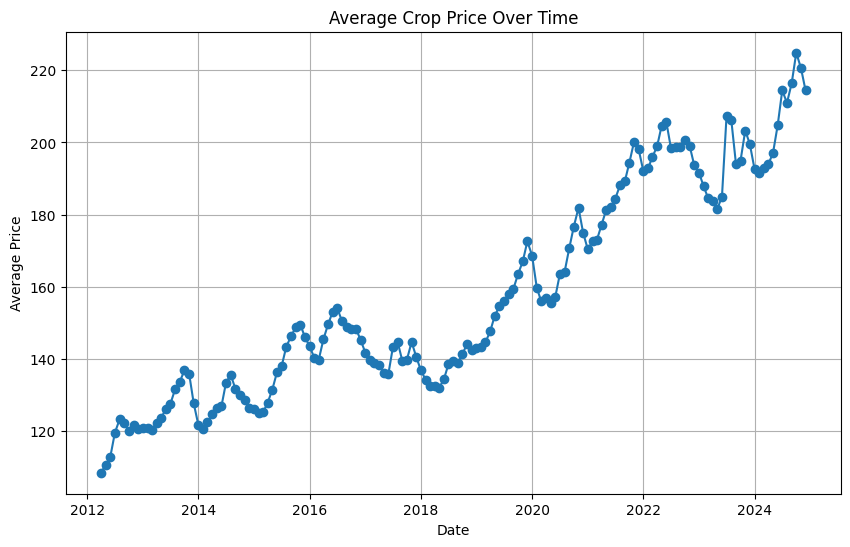

In [13]:
# Calculate average price over time
avg_price_over_time = df_long.groupby('Date')['Price'].mean()

# Plot average price over time
plt.figure(figsize=(10, 6))
plt.plot(avg_price_over_time.index, avg_price_over_time.values, marker='o')
plt.title('Average Crop Price Over Time')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.grid()
plt.show()

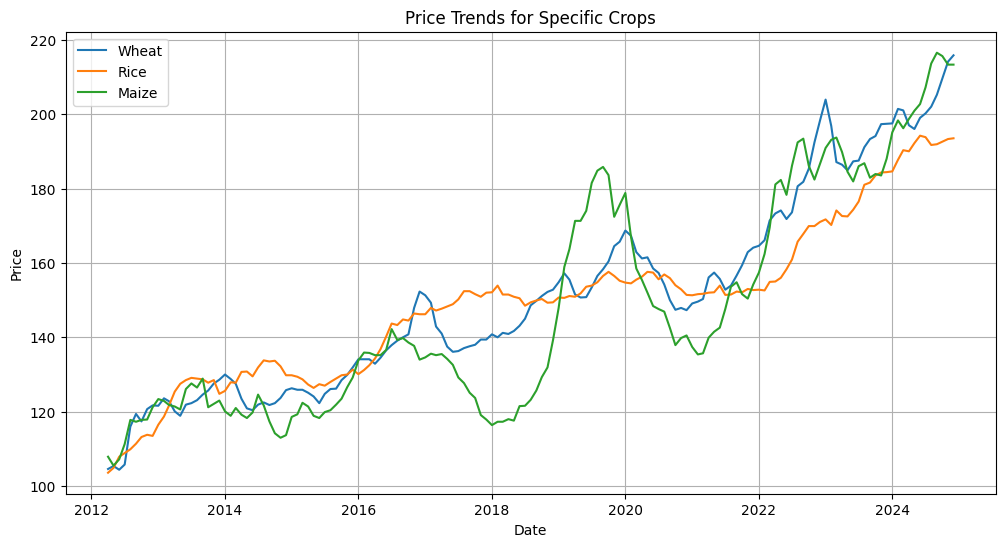

In [14]:
# Plot price trends for specific crops
crops_to_plot = ['Wheat', 'Rice', 'Maize']  # Example crops
plt.figure(figsize=(12, 6))
for crop in crops_to_plot:
    crop_data = df_long[df_long['Crop'] == crop]
    plt.plot(crop_data['Date'], crop_data['Price'], label=crop)

plt.title('Price Trends for Specific Crops')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

### Summary statistics for each crop 

In [15]:
print("Summary Statistics for Each Crop:")
print(df_long.groupby('Crop')['Price'].describe())

Summary Statistics for Each Crop:
                                count        mean         std    min    25%  \
Crop                                                                          
Bajra                           153.0  165.865359   40.044936  107.0  132.7   
Barley                          153.0  158.324183   35.184747  110.5  129.8   
Castorseed                      153.0  104.303268   17.311361   77.8   89.0   
Cotton                          153.0  121.804575   31.677944   83.4  102.0   
Cotton (Meal/Cake)              153.0  160.543137   28.463725  104.3  138.0   
Cotton Oil                      153.0  120.131373   26.135113   91.2  102.0   
Gram                            153.0  155.604575   35.978344   97.8  134.7   
Groundnut                       153.0  142.581699   29.370123   99.3  118.8   
Groundnut Oil                   153.0  131.098693   28.180660   90.1  109.8   
Jowar                           153.0  143.408497   39.209607   93.7  115.7   
Jute              

# Create sequences for LSTM 

In [16]:
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length)]
        y = data[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 12  # Use 12 months of data to predict the next month
X, y, crop_names, years, months = [], [], [], [], []  # Added months list

for crop in df_long['Crop'].unique():
    crop_data = df_long[df_long['Crop'] == crop]
    prices = crop_data['Price'].values
    dates = crop_data['Date'].dt.year.values
    month_values = crop_data['Date'].dt.month.values  # Extract month values for the crop
    
    # Create sequences for the crop
    X_crop, y_crop = create_sequences(prices, sequence_length)
    X.append(X_crop)
    y.append(y_crop)
    
    # Store crop names, years, and months for reference
    crop_names.extend([crop] * len(y_crop))
    years.extend(dates[sequence_length:])
    months.extend(month_values[sequence_length:])  # Append month values for valid sequences

# Concatenate all sequences
X = np.concatenate(X)
y = np.concatenate(y)

# Reshape X to be suitable for LSTM input
X = X.reshape((X.shape[0], X.shape[1], 1))

# Convert crop names to numerical labels
label_encoder = LabelEncoder()
crop_labels = label_encoder.fit_transform(crop_names)

# Combine crop labels, years, and months as additional input features
additional_features = np.column_stack((crop_labels, years, months))

# Normalize the additional features (crop label, year, and month)
scaler_features = MinMaxScaler()
additional_features = scaler_features.fit_transform(additional_features)

# Repeat additional features for each time step in the sequence
additional_features_repeated = np.repeat(additional_features[:, np.newaxis, :], sequence_length, axis=1)

# Combine sequences and additional features
X_combined = np.concatenate([X, additional_features_repeated], axis=2)

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

## LSTM MODEL 

In [17]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

In [18]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Display the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 50)         │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,501 (126.96 KB)

 Trainable params: 32,501 (126.96 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=100, 
                    batch_size=32, 
                    callbacks=[early_stop])

Epoch 1/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 23524.9531 - val_loss: 6713.6230
Epoch 2/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4822.3662 - val_loss: 2941.9651
Epoch 3/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3059.3381 - val_loss: 2631.6069
Epoch 4/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2327.5889 - val_loss: 1215.0768
Epoch 5/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1632.4386 - val_loss: 870.9187
Epoch 6/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1013.3576 - val_loss: 728.7698
Epoch 7/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1144.3416 - val_loss: 652.1479
Epoch 8/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 961.4548 - val_loss: 591.0433
Epoch 9/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 697.5996 - val_loss: 529.6600
Epoch 10/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 973.2252 - val_loss: 496.5124
Epoch 11/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 718.6406 - val_

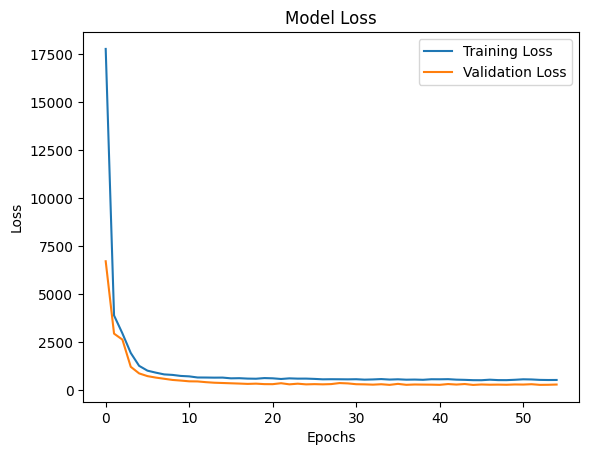

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 321.6204
Test Loss: 269.98980712890625


In [20]:
# Evaluate the model
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Function to evaluate model
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate model
mae, mse, rmse, r2 = evaluate_model(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Mean Absolute Error (MAE): 6.359150730090195
Mean Squared Error (MSE): 269.98978204271424
Root Mean Squared Error (RMSE): 16.431365799674545
R-squared (R²): 0.9082294670630867


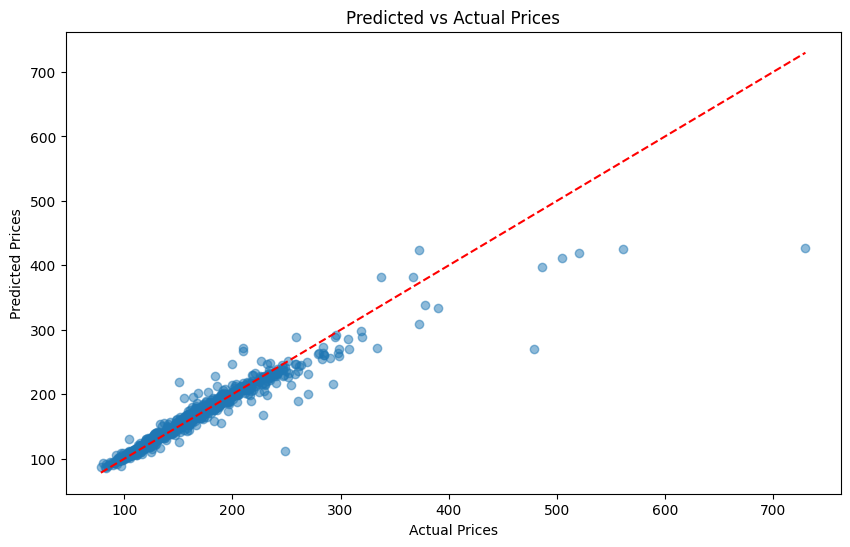

In [22]:
# Plot predicted vs actual prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Predicted vs Actual Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()

In [23]:
# Save the model and other components
model.save("my_model.keras")
joblib.dump(label_encoder, "label_encoder.pkl")
joblib.dump(scaler_features, "scaler_features.pkl")

['scaler_features.pkl']

In [25]:
# Function to predict price for a given crop, month, and year
def predict_price(crop_name, month, year, scaler, label_encoder, scaler_features, model, sequence_length):
    # Get the historical data for the crop
    crop_data = df_long[df_long['Crop'] == crop_name]
    prices = crop_data['Price'].values
    
    # Ensure we have enough historical data
    if len(prices) < sequence_length:
        raise ValueError(f"Not enough historical data for {crop_name}. Available: {len(prices)} months, Required: {sequence_length} months.")
    
    # Use the most recent sequence_length months of data
    input_sequence = prices[-sequence_length:]
    input_sequence = np.array(input_sequence).reshape(1, sequence_length, 1)
    
    # Encode the crop name
    crop_label = label_encoder.transform([crop_name])[0]
    
    # Normalize the additional features
    additional_features = scaler_features.transform([[crop_label, year, month]])
    year_normalized = additional_features[0][1]
    month_normalized = additional_features[0][2]
    
    # Repeat additional features for each time step
    additional_features_repeated = np.repeat([[crop_label, year_normalized, month_normalized]], sequence_length, axis=0).reshape(1, sequence_length, 3)
    
    # Combine the input sequence and additional features
    input_combined = np.concatenate([input_sequence, additional_features_repeated], axis=2)
    
    # Make the prediction
    predicted_price_normalized = model.predict(input_combined)
    
    # Inverse transform the predicted price to the original scale
    predicted_price = scaler.inverse_transform(predicted_price_normalized.reshape(-1, 1))[0][0]
    
    return predicted_price


# User input section
if __name__ == "__main__":
    # Take input from the user
    crop_name = input("Enter the crop name: ")
    month = int(input("Enter the month (1-12): "))
    year = int(input("Enter the year: "))
    
    # Validate inputs
    if month < 1 or month > 12:
        print("Invalid month. Please enter a value between 1 and 12.")
    elif year < 2012 or year > 2024:  # Adjust based on your dataset
        print("Invalid year. Please enter a year between 2012 and 2024.")
    else:
        try:
            # Predict the price
            predicted_price = predict_price(crop_name, month, year, scaler, label_encoder, scaler_features, model, sequence_length)
            print(f"Predicted price for {crop_name} in {month}/{year}: {predicted_price:.2f}")
        except ValueError as e:
            print(e)
            

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted price for Wheat in 8/2023: 299151.81


In [22]:
# model.save("my_model.keras")